In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
import timeit
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error


In [2]:
df = pd.read_csv('train.csv')
df.head()

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


In [3]:
df.shape

(333, 15)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 15 columns):
ID         333 non-null int64
crim       333 non-null float64
zn         333 non-null float64
indus      333 non-null float64
chas       333 non-null int64
nox        333 non-null float64
rm         333 non-null float64
age        333 non-null float64
dis        333 non-null float64
rad        333 non-null int64
tax        333 non-null int64
ptratio    333 non-null float64
black      333 non-null float64
lstat      333 non-null float64
medv       333 non-null float64
dtypes: float64(11), int64(4)
memory usage: 39.1 KB


In [5]:
df.isnull().sum()

ID         0
crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

In [6]:
# Finding and removing outliers
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
df.shape

(268, 15)

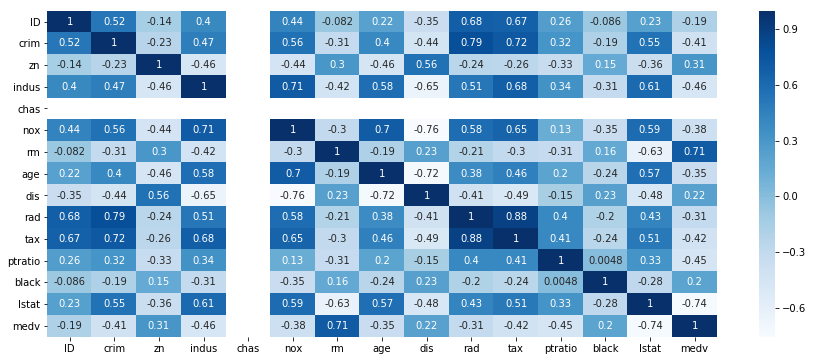

In [7]:
f= plt.figure(figsize=(15,6))
corr = df.corr()
ax = sns.heatmap(corr, cmap = 'Blues', annot= True)

From the correlation heatmap, we can see that __zn__, __rm__, __dis__, and __black__ has positive positive correlation score with target variable __medv__.

We are going to use these features to predict the target values.

In [8]:
df = df[['zn', 'rm', 'dis', 'black', 'medv']].reset_index()
df = df.drop(['index'], axis=1)
df.head()

,zn,rm,dis,black,medv
0,18.0,6.575,4.0900,396.90,24.0
1,0.0,6.421,4.9671,396.90,21.6
2,0.0,6.998,6.0622,394.63,33.4
3,0.0,7.147,6.0622,396.90,36.2
4,12.5,6.012,5.5605,395.60,22.9


### Feature Engineering

In [9]:
def scaling_features(data):
    """
        INPUT:
            data - Columns to be transformed
            
        OUTPUT:
            featurs_final - Transformed columns
    
    """
    scaler = MinMaxScaler()
    features = ['zn', 'rm', 'dis', 'black']
    features_minmax_transform = pd.DataFrame(data = data)
    features_minmax_transform[features] = scaler.fit_transform(data[features])
    return features_minmax_transform

In [11]:
df = scaling_features(df)
target = df['medv']
final_features = df[['zn', 'rm', 'dis', 'black']]
final_features.head()

,zn,rm,dis,black
0,0.240000,0.556059,0.362674,1.000000
1,0.000000,0.517259,0.471579,1.000000
2,0.000000,0.662635,0.607552,0.992349
3,0.000000,0.700176,0.607552,1.000000
4,0.166667,0.414210,0.545258,0.995619


### Training

In [46]:
def train_model(features, target_label):
    """
        INPUT:
            features  - Columns of the data that to be trained
            target_lable - Column that be predicted
        
        OUTPUT:
            my_rgr (instance of self) - Trained model            
    """
        
    start = timeit.default_timer()
    # Spliting the data
    X_train, X_test, y_train, y_test = train_test_split(features, target_label, test_size=0.3, random_state=42)
    
    # Creating object for LinearRegression model
    my_rgr = linear_model.LinearRegression()
    
    # Fitting data
    my_rgr = my_rgr.fit(X_train, y_train)
    
    end = timeit.default_timer()
    print("=========================================\n")
    print('Model trained in: ', end - start)
    print("\n=========================================")
    
    # returning X_train, X_test, y_train, y_test as it will be needed later for prediction and evaluation
    return my_rgr, X_train, X_test, y_train, y_test

In [47]:
model, X_train, X_test, y_train, y_test = train_model(final_features, target)


Model trained in:  0.00832109600014519



### Prediction

In [48]:
# Prediction on train set and test set
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)


### Evaluation

In [43]:
def Check_RMSE(y_true, y_predicted):
    RMSE = sqrt(mean_squared_error(y_true, y_predicted))
    return RMSE

In [49]:
print('RMSE value on Train Set: ', Check_RMSE(y_train, predictions_train))
print('RMSE value on Test Set: ', Check_RMSE(y_test, predictions_test))

RMSE value on Train Set:  5.066859377171858
RMSE value on Test Set:  6.670803445827987


### Prediction on new data

In [45]:
def pred_on_new_data(test_set):
    """
        INPUT:
            test_set (Dataframe) - Data to be predicted
            
        OUTPUT:
            final_pred (Dataframe) - Predicted column
    """
    
    test_features = scaling_features(test_set)
    final_pred = model.predict(test_features)
    
    return final_pred

In [38]:
test = pd.read_csv('test.csv')
test_id = test[['ID']]
test = test[['zn', 'rm', 'dis', 'black']]
final_pred = pred_on_new_data(test)
predicted_price = pd.DataFrame({'medv': final_pred})
output = test_id.join(predicted_price)
output

,ID,medv
0,3,28.478427
1,6,22.879899
2,8,21.430274
3,9,17.269733
4,10,20.109368
5,18,19.383925
6,20,17.416050
7,25,18.969038
8,26,15.655601
9,27,17.984534


In [39]:
output.to_csv('submission.csv', index=False)